In [1]:
import glob
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt

In [2]:
# from dwave.system import DWaveSampler, EmbeddingComposite # type: ignore
# from modules import construct_Ad, binary2real
# from modules import binary_least_squares_qubo, dict_to_vector_auto
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import os
# from tqdm import tqdm  # type: ignore

def find_intersections(sources, receivers, grid_size):
    all_intersections = []
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            x0, y0 = source
            x1, y1 = receiver
            dx = x1 - x0
            dy = y1 - y0

            for j in range(grid_size[0]):  # rows
                for k in range(grid_size[1]):  # columns
                    # Calculate intersections with grid lines
                    cell_x_min = k
                    cell_x_max = k + 1
                    cell_y_min = j
                    cell_y_max = j + 1
                    intersections = []

                    # Left boundary
                    if dx != 0:
                        t = (cell_x_min - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_min, y))

                    # Right boundary
                    if dx != 0:
                        t = (cell_x_max - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_max, y))

                    # Bottom boundary
                    if dy != 0:
                        t = (cell_y_min - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_min))

                    # Top boundary
                    if dy != 0:
                        t = (cell_y_max - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_max))

                    # Add entry and exit points
                    if (cell_x_min <= x0 <= cell_x_max) and (cell_y_min <= y0 <= cell_y_max):
                        intersections.append((x0, y0))
                    if (cell_x_min <= x1 <= cell_x_max) and (cell_y_min <= y1 <= cell_y_max):
                        intersections.append((x1, y1))

                    # Remove duplicate points
                    intersections = list(set(intersections))
                    # Sort intersections by distance from the source
                    intersections = sorted(intersections, key=lambda p: np.hypot(p[0] - x0, p[1] - y0))

                    # Add intersections to all_intersections
                    all_intersections.append(intersections)

    return all_intersections

# Remove duplicates from intersections
def remove_duplicate_intersections(intersections):
    seen = set()
    unique_intersections = []

    for point_pair in intersections:
        if tuple(point_pair) not in seen:
            unique_intersections.append(point_pair)
            seen.add(tuple(point_pair))
        else:
            unique_intersections.append([])

    return unique_intersections

# Calculate distances from unique intersections and store them in a NumPy array
def calculate_distances(unique_intersections, grid_size, sources, receivers):
    distances = np.zeros((grid_size[0], grid_size[1], len(receivers), len(sources)))
    idx = -1
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            for j in range(grid_size[0]):
                for k in range(grid_size[1]):
                    idx = idx + 1
                    intersections = unique_intersections[idx]
                    if len(intersections) >= 2:
                        total_distance = 0
                        for idxx in range(len(intersections) - 1):
                            d = np.hypot(intersections[idxx + 1][0] - intersections[idxx][0], intersections[idxx + 1][1] - intersections[idxx][1])
                            total_distance += d
                        distances[j, k, i, s_idx] = total_distance
                    else:
                        distances[j, k, i, s_idx] = 0
    return distances


def noise_generator(size, noise_level):
    noise = (np.random.rand(size))-0.5
    noise = noise*noise_level
    return noise

/tmp/ipykernel_19963/3886938565.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the colorbar


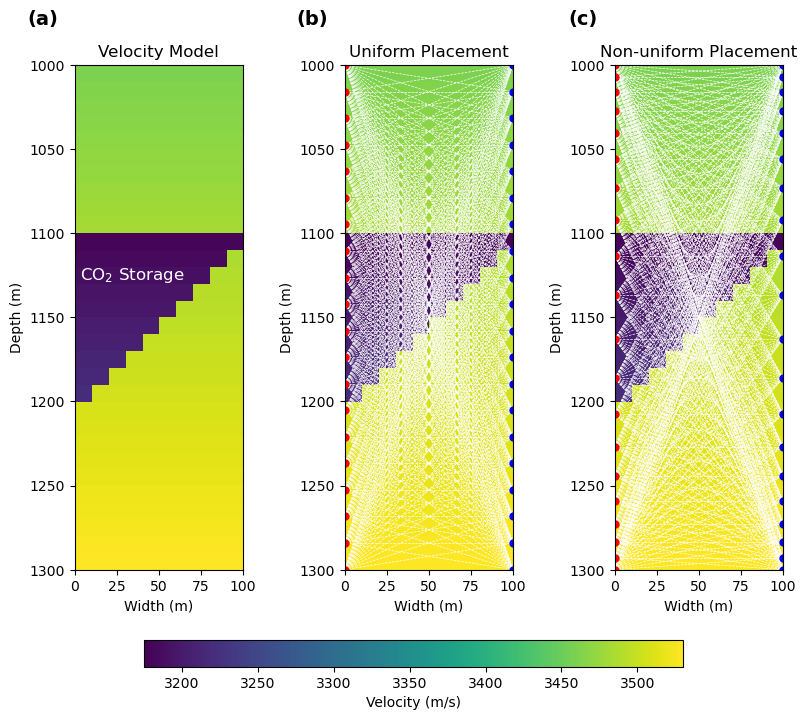

In [3]:
# Functions
def velocity_generator(rows, cols):
    grid_size = (rows, cols)
    min_velocity = 3460
    max_velocity = 3530
    wedge_min_velocity = 3180
    wedge_max_velocity = 3220
    wedge_start_row = 10
    wedge_end_row = 20

    # Create a background velocity model with values ranging from 3460 to 3530
    velocity_model = np.linspace(min_velocity, max_velocity, rows).reshape(-1, 1)
    velocity_model = np.repeat(velocity_model, cols, axis=1)

    # Create a triangular wedge shape with vertices at (0, 10), (0, 20), and (10, 10)
    for i in range(wedge_start_row, wedge_end_row):
        row_velocity = np.linspace(wedge_min_velocity, wedge_max_velocity, wedge_end_row - wedge_start_row)[i - wedge_start_row]
        num_cols_in_wedge = wedge_end_row - i
        velocity_model[i, :num_cols_in_wedge] = row_velocity
    return velocity_model

def plot_velocity_model(ax, velocity_model, extent):
    cax = ax.imshow(velocity_model, cmap='viridis', interpolation='nearest', extent=extent, origin='upper', vmin=3175, vmax=3530)
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Depth (m)')
    return cax

def plot_velocity_model_with_sources_and_receivers(ax, velocity_model, sources, receivers, extent, showlines, linecolor, linewidth):
    cax = ax.imshow(velocity_model, cmap='viridis', interpolation='nearest', extent=extent, origin='upper', vmin=3175, vmax=3530)
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Depth (m)')
    
    # Plot lines between sources and receivers
    if showlines:
        for source in sources:
            for receiver in receivers:
                ax.plot([source[0], receiver[0]], [source[1], receiver[1]], color=linecolor, linestyle='--', linewidth=linewidth)

    # Plot the sources and receivers
    for source in sources:
        ax.plot(source[0], source[1], marker='o', color='red', markersize=5)

    for receiver in receivers:
        ax.plot(receiver[0], receiver[1], marker='o', color='blue', markersize=5)
    
    return cax

def device_location(n, rows, new_min, new_max, linear):
    if linear:
        z4 = np.linspace(new_min, new_max, n)
    else:
        n2 = int(np.ceil(n/2))
        rows2 = rows/2 - 1.3
        x = np.array([x for x in range(n2)])
        y = np.array([(i+3)**2 for i in x])
        z = (y - y[0]) * rows2 / (y[-1] - y[0])
        z1 = 15 - z + 15
        z2 = z1[::-1]
        z3 = np.concatenate((z, z2))
        z4 = rescale(z3, new_min, new_max) # Rescale array to range
    return z4

def rescale(arr, new_min, new_max):
    old_min = np.min(arr)
    old_max = np.max(arr)
    return (new_max - new_min) * (arr - old_min) / (old_max - old_min) + new_min

# Define the velocity model
rows, cols = 30, 10
grid_size = (rows, cols)
velocity_model = velocity_generator(rows, cols)

# Define the extent
extent = [0, 100, 1300, 1000]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(11/4*3, 7))  # Adjust to 3 subplots

# First plot (without sources and receivers)
cax1 = plot_velocity_model(axs[0], velocity_model, extent)
axs[0].set_title('Velocity Model')

# Add "CO₂ Storage" text in the left middle of the first figure
axs[0].text(34, 1125, 'CO$_2$ Storage', fontsize=12, color='white', verticalalignment='center', horizontalalignment='center')

# Second plot
z = device_location(n=20, rows=rows, new_min=extent[2], new_max=extent[3], linear=True)
sources = [(extent[0], i) for i in z]
receivers = [(extent[1], i) for i in z]
cax2 = plot_velocity_model_with_sources_and_receivers(axs[1], velocity_model, sources, receivers, extent, showlines=True, linecolor='white', linewidth=.5)
axs[1].set_title('Uniform Placement')

# Third plot
z = device_location(n=20, rows=rows, new_min=extent[2], new_max=extent[3], linear=False)
sources = [(extent[0], i) for i in z]
receivers = [(extent[1], i) for i in z]
cax3 = plot_velocity_model_with_sources_and_receivers(axs[2], velocity_model, sources, receivers, extent, showlines=True, linecolor='white', linewidth=.5)
axs[2].set_title('Non-uniform Placement')

# Add labels "a", "b", and "c" to the subplots
axs[0].text(-0.1, 1.11, '(a)', transform=axs[0].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
axs[1].text(-0.1, 1.11, '(b)', transform=axs[1].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
axs[2].text(-0.1, 1.11, '(c)', transform=axs[2].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

# Add a colorbar to the figure
cbar = fig.colorbar(cax1, ax=axs, orientation='horizontal', fraction=0.05, pad=-0.2)
cbar.set_label('Velocity (m/s)')

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the colorbar
plt.show()
fig.savefig('plots/ray_coverage.png', bbox_inches='tight', dpi=300)  # Save with desired DPI and tight bounding box


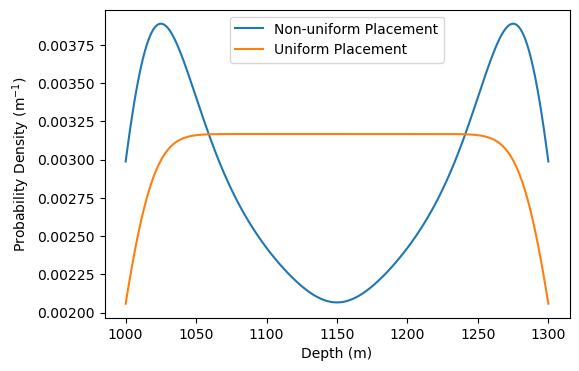

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def rescale(arr, new_min, new_max):
    old_min = np.min(arr)
    old_max = np.max(arr)
    return (new_max - new_min) * (arr - old_min) / (old_max - old_min) + new_min

def device_location(n, rows, new_min, new_max, linear):
    if linear:
        z4 = np.linspace(new_min, new_max, n)
    else:
        n2 = int(np.ceil(n/2))
        rows2 = rows / 2 - 1.3
        x = np.array([x for x in range(n2)])
        y = np.array([(i + 3)**2 for i in x])
        z = (y - y[0]) * rows2 / (y[-1] - y[0])
        z1 = 15 - z + 15
        z2 = z1[::-1]
        z3 = np.concatenate((z, z2))
        z4 = rescale(z3, new_min, new_max) # Rescale array to range
    return z4

def plot_density(z, title):
    density = gaussian_kde(z)
    xs = np.linspace(min(z), max(z), 200)
    # density.covariance_factor = lambda : .25
    density.covariance_factor = lambda : .225
    density._compute_covariance()

    plt.plot(xs, density(xs), label=title)
    plt.xlabel('Depth (m)')
    plt.ylabel(r'Probability Density (m$^{-1}$)')
    # plt.title('Distribution of Source and Receiver Locations')
    plt.legend()

# Define parameters
rows = 30
n = 20
new_min = 1000
new_max = 1300
plt.figure(figsize=([6,4]))
# Generate and plot non-linear device locations
z_non_linear = device_location(n, rows, new_min, new_max, linear=False)
plot_density(z_non_linear, 'Non-uniform Placement')

# Generate and plot linear device locations
z_linear = device_location(n, rows, new_min, new_max, linear=True)
plot_density(z_linear, 'Uniform Placement')

# Save figure before showing it
plt.savefig('plots/distri_sour_rec.png', bbox_inches='tight', dpi=300)

# Show plot
plt.show()


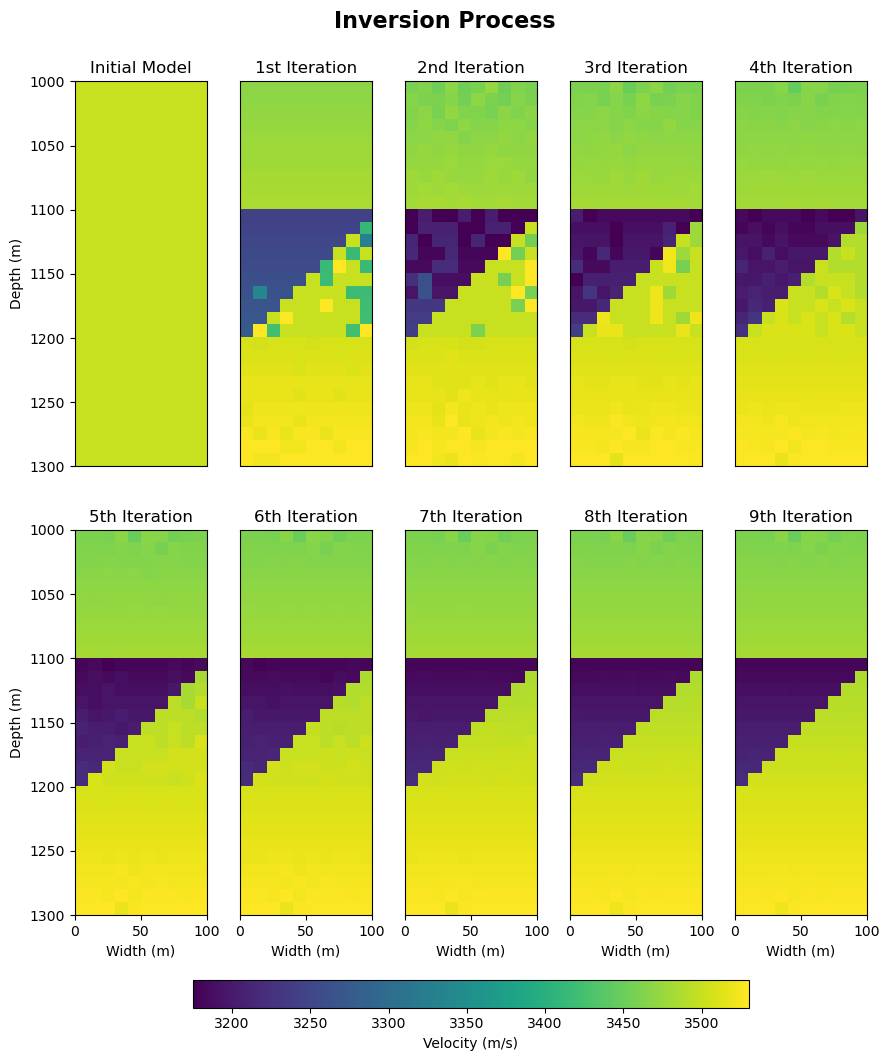

In [5]:
import glob
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt

# Base directory where the folders are located
base_directory = 'results30x10'

# Use glob to find all .txt files in the directory and subdirectories
file_paths = glob.glob(f'{base_directory}/*/*.txt', recursive=True)
file_paths = natsorted(file_paths)

# Function to read all .txt files
def read_all_txt_files(file_paths):
    data = []
    for file_path in file_paths:
        file_data = np.loadtxt(file_path)
        data.append(file_data)
    return data

# Read all .txt files and store their content
s = np.array(read_all_txt_files(file_paths))

data = [s[i::10] for i in range(10)]
data = np.array(data)
velocity_inversion = 1 / data

# Helper function to create ordinal labels
def ordinal(n):
    return "%d%s" % (n, "tsnrhtdd"[(n // 10 % 10 != 1) * (n % 10 < 4) * n % 10::4])

# Create a 2x5 grid to display the matrices using imshow
cols = 5  # Number of columns
rows = 2  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(9, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

vmin, vmax = 3175, 3530
extent = [0, 100, 1300, 1000]  # Set the desired extent

velocity_initial = np.full((30, 10), 3500)

# Loop through each matrix and plot
for i in range(10):
    if i == 0:
        # Plot the initial velocity for the first subplot
        im = axes[i].imshow(velocity_initial, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
        axes[i].set_title('Initial Model')
    else:
        # Plot the inverted velocity models from 1 to 9
        im = axes[i].imshow(velocity_inversion[i-1], cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
        axes[i].set_title(f'{ordinal(i)} Iteration')

    # Set custom labels for specific subplots
    if i == 0:
        axes[i].set_ylabel('Depth (m)')
        axes[i].set_xticks([])
    elif i == 5:
        axes[i].set_xlabel('Width (m)')
        axes[i].set_ylabel('Depth (m)')
    elif i >= 6:
        axes[i].set_xlabel('Width (m)')
        axes[i].set_yticks([])
    else:
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust the layout to make room for the colorbar at the bottom
fig.tight_layout(rect=[0, 0.1, 1, 0.95], h_pad=3.0)  # Increase h_pad to add more space between rows

# Add a single colorbar for all subplots at the bottom
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.03, pad=0.07)
cbar.set_label('Velocity (m/s)')

# Add a title for the entire plot
fig.suptitle('Inversion Process', fontsize=16, fontweight='bold')

plt.show()
fig.savefig('plots/result10loops.png', bbox_inches='tight', dpi=300)  # Save with desired DPI and tight bounding box


/tmp/ipykernel_19963/2590940525.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the colorbars


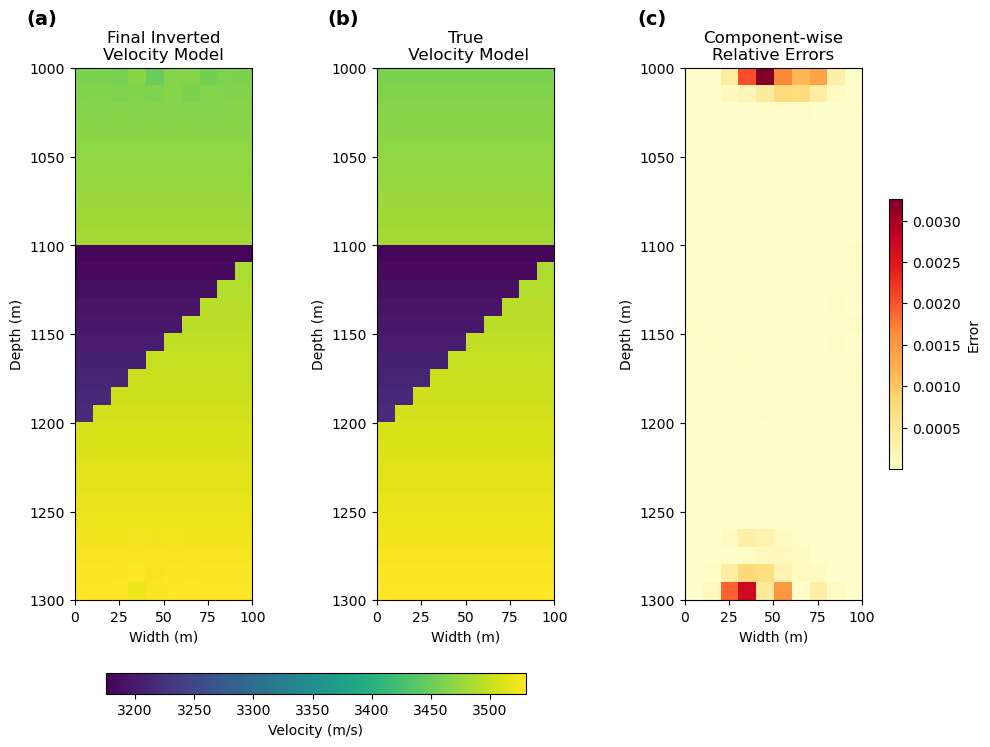

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define models
rows, cols = 30, 10
grid_size = (rows, cols)
min_velocity = 3460
max_velocity = 3530
wedge_min_velocity = 3180
wedge_max_velocity = 3220
wedge_start_row = 10
wedge_end_row = 20

# Create a background velocity model with values ranging from 3460 to 3530
velocity_model = np.linspace(min_velocity, max_velocity, rows).reshape(-1, 1)
velocity_model = np.repeat(velocity_model, cols, axis=1)
velocity_initial = np.full((30, 10), 3500)

# Create a triangular wedge shape with vertices at (0, 10), (0, 20), and (10, 10)
for i in range(wedge_start_row, wedge_end_row):
    row_velocity = np.linspace(wedge_min_velocity, wedge_max_velocity, wedge_end_row - wedge_start_row)[i - wedge_start_row]
    num_cols_in_wedge = wedge_end_row - i
    velocity_model[i, :num_cols_in_wedge] = row_velocity

# Define the extent
extent = [0, 100, 1300, 1000]

# Create the 1x3 grid layout
fig, axs = plt.subplots(1, 3, figsize=(10, 7))

# Second plot: Inverted Velocity
im1 = axs[0].imshow(velocity_inversion[9], cmap='viridis', interpolation='nearest', extent=extent, origin='upper', vmin=3175, vmax=3530)
axs[0].set_title('Final Inverted\nVelocity Model')
axs[0].set_xlabel('Width (m)')
axs[0].set_ylabel('Depth (m)')

# Third plot: Velocity Model
im2 = axs[1].imshow(velocity_model, cmap='viridis', interpolation='nearest', extent=extent, origin='upper', vmin=3175, vmax=3530)
axs[1].set_title('True\n Velocity Model')
axs[1].set_xlabel('Width (m)')
axs[1].set_ylabel('Depth (m)')

# Fourth plot: Difference
relative_error = np.abs((velocity_model - velocity_inversion[9]) / velocity_model)
im3 = axs[2].imshow(relative_error, cmap='YlOrRd', interpolation='nearest', extent=extent, origin='upper')
axs[2].set_title('Component-wise\nRelative Errors')
axs[2].set_xlabel('Width (m)')
axs[2].set_ylabel('Depth (m)')

# Add a single colorbar for the first two subplots
cbar1 = fig.colorbar(im1, ax=axs[:2], orientation='horizontal', fraction=0.05, pad=0.2)
cbar1.ax.set_position([-0.03, 0.00, 0.7, 0.03])  # [left, bottom, width, height]
cbar1.set_label('Velocity (m/s)')

# Add a separate vertical colorbar for the third subplot
cbar2 = fig.colorbar(im3, ax=axs[2], orientation='vertical', fraction=0.05, pad=0.1)
cbar2.set_label('Error')

# Add labels "a", "b", and "c" to the subplots
axs[0].text(-0.1, 1.11, '(a)', transform=axs[0].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
axs[1].text(-0.1, 1.11, '(b)', transform=axs[1].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')
axs[2].text(-0.1, 1.11, '(c)', transform=axs[2].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make room for the colorbars
plt.show()
fig.savefig('plots/result_diff.png', bbox_inches='tight', dpi=300)  # Save with desired DPI and tight bounding box


Noisy - Step by Step

In [7]:
import glob
import numpy as np
from natsort import natsorted # type: ignore
import matplotlib.pyplot as plt


# Base directory where the folders are located
base_directory = 'results30x10-noise-2'

# Use glob to find all .txt files in the directory and subdirectories
file_paths = glob.glob(f'{base_directory}/*/*.txt', recursive=True)
file_paths = natsorted(file_paths)

# Function to read all .txt files
def read_all_txt_files(file_paths):
    data = []
    for file_path in file_paths:
        file_data = np.loadtxt(file_path)
        data.append((file_data))
    return data

# Read all .txt files and store their content
s = np.array(read_all_txt_files(file_paths))
# np.savetxt('slowness30x10.csv', s, delimiter=',', fmt='%.12f')

data = [s[i::10] for i in range(10)]
data = np.array(data)
velocity_inversion = 1/data

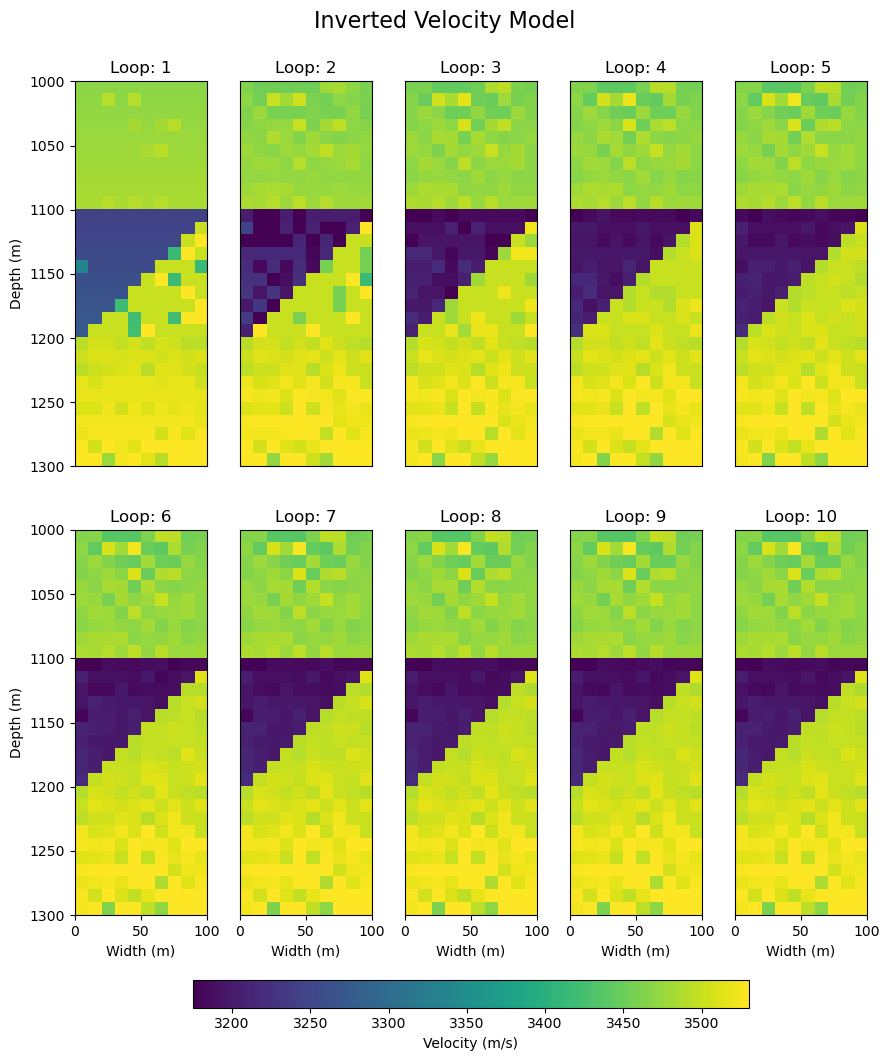

In [8]:
# Create a 2x5 grid to display the matrices using imshow
cols = 5  # Number of columns
rows = 2  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(9, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

vmin, vmax = 3175, 3530


# Loop through each matrix and plot
for i, data in enumerate(velocity_inversion):
    # Plot the data
    im = axes[i].imshow(data, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
    axes[i].set_title(f'Loop: {i+1}')

    # Set custom labels for specific subplots
    if i == 0:
        axes[i].set_ylabel('Depth (m)')
        axes[i].set_xticks([])
    elif i == 5:
        axes[i].set_xlabel('Width (m)')
        axes[i].set_ylabel('Depth (m)')
    elif i >= 6:
        axes[i].set_xlabel('Width (m)')
        axes[i].set_yticks([])
    else:
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust the layout to make room for the colorbar at the bottom
fig.tight_layout(rect=[0, 0.1, 1, 0.95], h_pad=3.0)  # Increase h_pad to add more space between rows

# Add a single colorbar for all subplots at the bottom
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.03, pad=0.07)
cbar.set_label('Velocity (m/s)')

# Add a title for the entire plot
fig.suptitle('Inverted Velocity Model', fontsize=16)

plt.show()
fig.savefig('plots/result10loops_noise.png', bbox_inches='tight', dpi=300)  # Save with desired DPI and tight bounding box

Noisy - Results

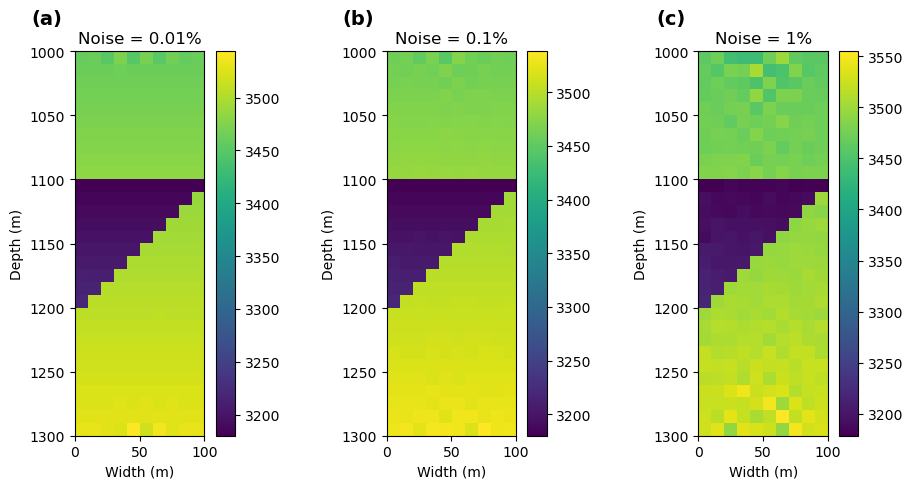

In [9]:
import glob
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt

# Base directories where the folders are located
base_directories = ['results30x10-noise-001', 'results30x10-noise-01', 'results30x10-noise-1']

# List to store velocity inversion data
velocity_inversions_quantum = []

# Iterate over each base directory
for base_directory in base_directories:
    # Use glob to find all .txt files in the directory and subdirectories
    file_paths = glob.glob(f'{base_directory}/*/*.txt', recursive=True)
    file_paths = natsorted(file_paths)

    # Read all .txt files and store their content
    s = np.array([np.loadtxt(file_path) for file_path in file_paths])
    data = np.array([s[i::10] for i in range(10)])
    velocity_inversions_quantum.append(1 / data)

# Plot the velocity inversion for each noise level
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

titles = ['Noise = 0.01%', 'Noise = 0.1%', 'Noise = 1%']

# Define the extent and color limits

for i, (velocity_inversion, title) in enumerate(zip(velocity_inversions_quantum, titles)):
    im = axs[i].imshow(velocity_inversion[9], cmap='viridis', aspect='auto', extent=extent)
    axs[i].set_title(title)
    axs[i].set_xlabel('Width (m)')
    axs[i].set_ylabel('Depth (m)')
    fig.colorbar(im, ax=axs[i], fraction=0.5, pad=0.04)

# Add labels "a", "b", and "c" to the subplots
labels = ['(a)', '(b)', '(c)']
for i, label in enumerate(labels):
    axs[i].text(-0.1, 1.11, label, transform=axs[i].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/result_quan_noise.png', bbox_inches='tight', dpi=300)
plt.show()


Noisy - Classical

In [10]:
# from dwave.system import DWaveSampler, EmbeddingComposite # type: ignore
# from modules import construct_Ad, binary2real
# from modules import binary_least_squares_qubo, dict_to_vector_auto
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import os
# from tqdm import tqdm  # type: ignore

# Functions

def find_intersections(sources, receivers, grid_size):
    all_intersections = []
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            x0, y0 = source
            x1, y1 = receiver
            dx = x1 - x0
            dy = y1 - y0

            for j in range(grid_size[0]):  # rows
                for k in range(grid_size[1]):  # columns
                    # Calculate intersections with grid lines
                    cell_x_min = k
                    cell_x_max = k + 1
                    cell_y_min = j
                    cell_y_max = j + 1
                    intersections = []

                    # Left boundary
                    if dx != 0:
                        t = (cell_x_min - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_min, y))

                    # Right boundary
                    if dx != 0:
                        t = (cell_x_max - x0) / dx
                        if 0 <= t <= 1:
                            y = y0 + t * dy
                            if cell_y_min <= y <= cell_y_max:
                                intersections.append((cell_x_max, y))

                    # Bottom boundary
                    if dy != 0:
                        t = (cell_y_min - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_min))

                    # Top boundary
                    if dy != 0:
                        t = (cell_y_max - y0) / dy
                        if 0 <= t <= 1:
                            x = x0 + t * dx
                            if cell_x_min <= x <= cell_x_max:
                                intersections.append((x, cell_y_max))

                    # Add entry and exit points
                    if (cell_x_min <= x0 <= cell_x_max) and (cell_y_min <= y0 <= cell_y_max):
                        intersections.append((x0, y0))
                    if (cell_x_min <= x1 <= cell_x_max) and (cell_y_min <= y1 <= cell_y_max):
                        intersections.append((x1, y1))

                    # Remove duplicate points
                    intersections = list(set(intersections))
                    # Sort intersections by distance from the source
                    intersections = sorted(intersections, key=lambda p: np.hypot(p[0] - x0, p[1] - y0))

                    # Add intersections to all_intersections
                    all_intersections.append(intersections)

    return all_intersections

# Remove duplicates from intersections
def remove_duplicate_intersections(intersections):
    seen = set()
    unique_intersections = []

    for point_pair in intersections:
        if tuple(point_pair) not in seen:
            unique_intersections.append(point_pair)
            seen.add(tuple(point_pair))
        else:
            unique_intersections.append([])

    return unique_intersections

# Calculate distances from unique intersections and store them in a NumPy array
def calculate_distances(unique_intersections, grid_size, sources, receivers):
    distances = np.zeros((grid_size[0], grid_size[1], len(receivers), len(sources)))
    idx = -1
    for s_idx, source in enumerate(sources):
        for i, receiver in enumerate(receivers):
            for j in range(grid_size[0]):
                for k in range(grid_size[1]):
                    idx = idx + 1
                    intersections = unique_intersections[idx]
                    if len(intersections) >= 2:
                        total_distance = 0
                        for idxx in range(len(intersections) - 1):
                            d = np.hypot(intersections[idxx + 1][0] - intersections[idxx][0], intersections[idxx + 1][1] - intersections[idxx][1])
                            total_distance += d
                        distances[j, k, i, s_idx] = total_distance
                    else:
                        distances[j, k, i, s_idx] = 0
    return distances

def rescale(arr, new_min, new_max):
    old_min = np.min(arr)
    old_max = np.max(arr)
    return (new_max - new_min) * (arr - old_min) / (old_max - old_min) + new_min

def device_location(n, rows, new_min, new_max, linear):
    if linear == True:
        z4 = np.linspace(new_min, new_max, n)
    else:
        n2 = int(np.ceil(n/2))
        rows2 = rows/2 - 1.3
        x = np.array([x for x in range(n2)])
        y = np.array([(i+3)**2 for i in x])
        z = (y - y[0]) * rows2 / (y[-1] - y[0])
        z1 = 15 - z + 15
        z2 = z1[::-1]
        z3 = np.concatenate((z, z2))
        z4 = rescale(z3, new_min, new_max) # Rescale array to range
    return z4


def noise_generator(size, noise_level):
    noise = (np.random.rand(size))-0.5
    noise = noise*noise_level
    return noise

In [11]:
# Defind the velocity model
rows, cols = 30, 10
grid_size = (rows, cols)
velocity_model = velocity_generator(rows, cols)

# Define sources and receivers
# 0.1 and 29.9 are values close to limits
# Change linear to True to generate regular locations

# NOTE: create the z position not on the grid boundary to avoid conflict
z = device_location(n=20, rows=rows, new_min=0.1, new_max=29.9, linear=False)
sources = [(0, i) for i in z]
receivers = [(cols, i ) for i in z]

intersections = find_intersections(sources, receivers, grid_size=grid_size)
unique_intersections = remove_duplicate_intersections(intersections)
distances = calculate_distances(unique_intersections, grid_size=grid_size, sources=sources, receivers=receivers)


D = []
T = []
s1 = 1/velocity_model

nreceiver = len(receivers)
nsource = len(sources)

for i in range(nsource):
    for j in range(nreceiver):
        D.append(distances[:,:,j,i].flatten())
        T.append(sum(sum(distances[:,:,j,i]*s1)))    
D = np.array(D)
Df = pd.DataFrame(D)
s1 = s1.flatten()


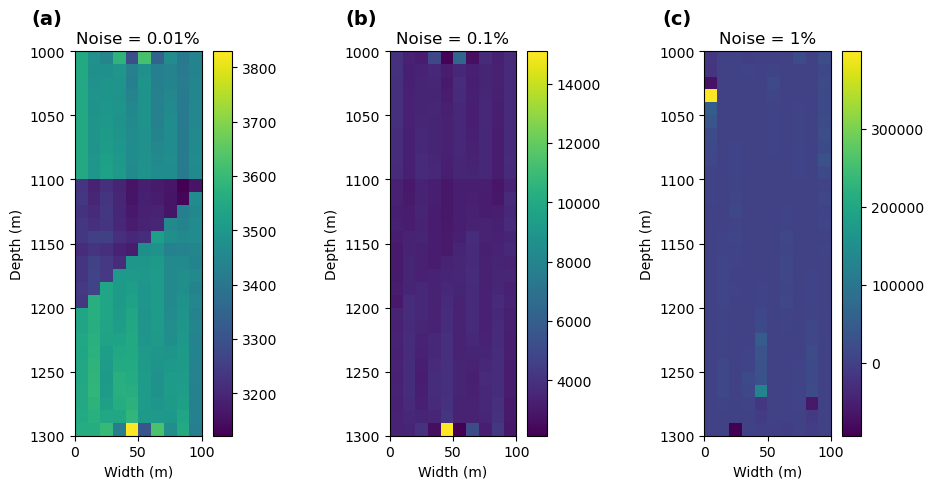

In [12]:
# Noise levels to process
noise_levels = [0.0001, 0.001, 0.01]
velocity_inversions = []

# Loop through each noise level and compute velocity inversion
for noise_level in noise_levels:
    np.random.seed(99)
    noise_percent = noise_generator(size=400, noise_level=noise_level)
    T_noise = T + noise_percent * T
    s, residuals, rank, s_val = np.linalg.lstsq(D, T_noise, rcond=None)
    v_inversion = s**-1
    v_inversion = v_inversion.reshape(rows, cols)
    velocity_inversions.append(v_inversion)




# Plot each velocity inversion in a single figure
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
titles = ['Noise = 0.01%', 'Noise = 0.1%', 'Noise = 1%']

for i, (velocity_inversion, title) in enumerate(zip(velocity_inversions, titles)):
    im = axs[i].imshow(velocity_inversion, cmap='viridis', aspect='auto', extent=extent)
    axs[i].set_title(title)
    axs[i].set_xlabel('Width (m)')
    axs[i].set_ylabel('Depth (m)')
    fig.colorbar(im, ax=axs[i], fraction=0.5, pad=0.04)

# Add labels "a", "b", and "c" to the subplots
labels = ['(a)', '(b)', '(c)']
for i, label in enumerate(labels):
    axs[i].text(-0.1, 1.11, label, transform=axs[i].transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/result_classical_noise.png', bbox_inches='tight', dpi=300)
plt.show()



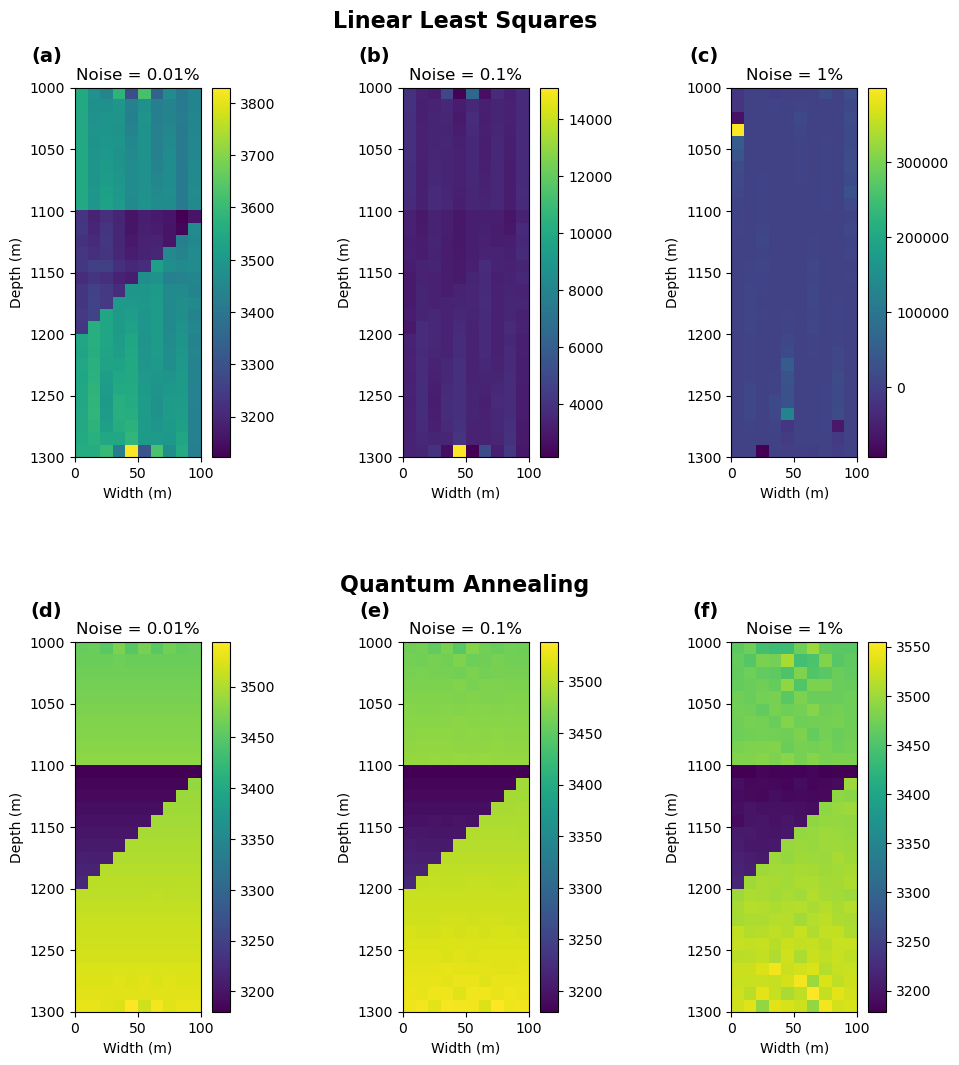

In [13]:
import matplotlib.gridspec as gridspec

# Create a 2x3 grid of subplots with more space between the rows
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], hspace=0.5)

# Titles for each subplot
titles = ['Noise = 0.01%', 'Noise = 0.1%', 'Noise = 1%']

# Plot the velocity inversion for the classical noise data (Linear Least Squares) first
main_axes = []  # To store main plot axes
for i, (velocity_inversion, title) in enumerate(zip(velocity_inversions, titles)):
    ax = fig.add_subplot(gs[0, i])
    main_axes.append(ax)
    im = ax.imshow(velocity_inversion, cmap='viridis', aspect='auto', extent=extent)
    ax.set_title(f'{title}')
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Depth (m)')
    fig.colorbar(im, ax=ax, fraction=0.5, pad=0.04)

# Plot the velocity inversion for freenoise data (Quantum Annealing) next
for i, (velocity_inversion, title) in enumerate(zip(velocity_inversions_quantum, titles)):
    ax = fig.add_subplot(gs[1, i])
    main_axes.append(ax)
    im = ax.imshow(velocity_inversion[9], cmap='viridis', aspect='auto', extent=extent)
    ax.set_title(f'{title}')
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Depth (m)')
    fig.colorbar(im, ax=ax, fraction=0.5, pad=0.04)

# Add labels to the main subplots only
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, ax in enumerate(main_axes):
    ax.text(-0.1, 1.11, labels[i], transform=ax.transAxes, fontsize=14, va='top', ha='right', fontweight='bold')

# Add overarching titles for the rows
fig.text(0.45, 0.93, 'Linear Least Squares', ha='center', fontsize=16, fontweight='bold')
fig.text(0.45, 0.46, 'Quantum Annealing', ha='center', fontsize=16, fontweight='bold')

# Save the figure
plt.savefig('plots/combined_velocity_inversions.png', bbox_inches='tight', dpi=300)
plt.show()
